# AAI 511 - Assignment 5 - Natural Language Processing

by Bryan Carr

1 August, 2022

for USD's AAI 511 Course


In this assignment, we will build a classifier for the well known IMDB dataset of movie reviews. The intent is to create a basic sentiment analyzer, to classify reviews as having a positive or negative impression of the movies. We will build this as a RNN into a Dense layer for classification.

First we will import some of the key libraries, and read in the data.

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, SimpleRNN, Embedding, LSTM
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score


In [ ]:
# Set Random Seeds

np.random.seed(801)
tf.random.set_seed(801)

In [ ]:
# Import the data
from keras.datasets import imdb

In [ ]:
# We want to determine the most frequent words which we should skip
# Load in the word dictionary
review_dict = imdb.get_word_index(path="imdb_word_index.json")


1654784/1641221 [==============================] - 0s 0us/step


In [ ]:
# Print 30 most common words

for keys, values in review_dict.items():
  for i in range (1,30):
    if values == i: print(str(values) + " -> key: " + str(keys))

16 -> key: with
28 -> key: one
25 -> key: have
10 -> key: i
26 -> key: he
14 -> key: as
9 -> key: it
6 -> key: is
8 -> key: in
18 -> key: but
20 -> key: on
4 -> key: of
24 -> key: his
29 -> key: all
11 -> key: this
21 -> key: not
22 -> key: you
3 -> key: a
15 -> key: for
27 -> key: be
7 -> key: br
1 -> key: the
13 -> key: was
2 -> key: and
5 -> key: to
19 -> key: film
17 -> key: movie
12 -> key: that
23 -> key: are


I would expect the word 'But' at index=18 to start to be important. Certainly 'Not' at index=21 would be important. We might also expect 'Was' at index=13 to convey conditions. 

Therefore I will set my cutoff lower, at 10, to remove the 10 most common words.

I will also limit the number of words to the 20,000 most frequent, to help limit the overall size of the dataset.

In [ ]:
# Load in the data
# With OOV_Char = None, the truncated and removed words will not be replaced with anything, giving us the desired smaller dataset

max_words = 20000

(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=max_words,
                                                      skip_top=10,
                                                      maxlen=None,
                                                      seed=801,
                                                      start_char=1,
                                                      oov_char=None,
                                                      index_from=3
                                                      )


17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
# View a sample of the first 3 entries
x_train[0:3]

array([list([348, 425, 7497, 953, 498, 13, 16, 1623, 18, 43, 44, 233, 382, 61, 6615, 71, 918, 43, 227, 312, 88, 13, 16, 317, 117, 2245, 10, 10, 22, 1051, 780, 23, 1796, 2026, 383, 20, 130, 56, 33, 680, 313, 54, 36, 79, 416, 11, 5382, 1197, 118, 96, 1142, 2193, 28, 383, 121, 1481, 14, 270, 56, 77, 343, 159, 1474, 133, 9325, 8383, 876, 383, 24, 1668, 123, 32, 6610, 13299, 665, 71, 4667, 11, 1898, 18, 196, 58, 51, 617, 46, 20, 497, 17, 254, 17, 12, 70, 123, 529, 43, 89, 7670, 383, 70, 30, 10, 10, 6929, 32, 9574, 7787, 23, 7934, 969, 625, 6174, 13, 191, 10783, 287, 56, 778, 5330, 349, 10084, 372, 95, 5330, 98, 99, 49, 7324, 26, 227, 76, 91, 3735, 255, 260, 41, 9465, 1906, 46, 143, 41, 14170, 42, 160, 255, 9162, 46, 538, 21, 900, 599, 184, 1273, 2396, 10, 10, 1116, 22, 1906, 180, 34, 45, 205, 4627, 45, 99, 120, 16795, 30, 16537, 189, 431, 99, 2943, 157, 17, 383, 509, 18351, 70, 157, 21, 50, 359, 30, 2972, 10, 10, 470, 158]),
       list([4682, 312, 382, 91, 2184, 1179, 509, 3486, 12, 31, 17

In [ ]:
y_train

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
x_train.shape

(25000,)

In [ ]:
y_train.shape

(25000,)

In [ ]:
x_test.shape

(25000,)

## Preprocessing

We will now preprocess our data with Pad_Sequences. This will cut/truncate our data down to that point, which should be enough to give us a positive or negative impression of the reviews.

In [ ]:
maxlength = 100

x_train = pad_sequences(x_train, maxlen=maxlength)
x_test = pad_sequences(x_test, maxlen=maxlength)

In [ ]:
# Check the first 3 entries
x_train[0:3]


array([[   17,    12,    70,   123,   529,    43,    89,  7670,   383,
           70,    30,    10,    10,  6929,    32,  9574,  7787,    23,
         7934,   969,   625,  6174,    13,   191, 10783,   287,    56,
          778,  5330,   349, 10084,   372,    95,  5330,    98,    99,
           49,  7324,    26,   227,    76,    91,  3735,   255,   260,
           41,  9465,  1906,    46,   143,    41, 14170,    42,   160,
          255,  9162,    46,   538,    21,   900,   599,   184,  1273,
         2396,    10,    10,  1116,    22,  1906,   180,    34,    45,
          205,  4627,    45,    99,   120, 16795,    30, 16537,   189,
          431,    99,  2943,   157,    17,   383,   509, 18351,    70,
          157,    21,    50,   359,    30,  2972,    10,    10,   470,
          158],
       [ 1583,    83,    37,    62,   104,    45,    52,   326,  3163,
         3640, 10257,   258,    11,  2628,  1430,    11,   673,    15,
          571,    28,    68,   154,    17,    73,    17,    2

In [ ]:
x_train.shape

(25000, 100)

In [ ]:
x_test.shape

(25000, 100)

## Build the Simple RNN

We will now build a classifier using a Simple RNN layer.

We will build an embedding layer with 32 dimensions (a seemingly standard number).

In [ ]:
rnn_classifier = Sequential()

rnn_classifier.add(Embedding(max_words, 32, input_length=maxlength ) )

rnn_classifier.add(SimpleRNN(20, input_shape = (max_words, maxlength) ))
rnn_classifier.add(Dropout(0.2))

rnn_classifier.add(Dense(1, activation='sigmoid', name='output'))

In [ ]:
rnn_classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 20)                1060      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 output (Dense)              (None, 1)                 21        
                                                                 
Total params: 641,081
Trainable params: 641,081
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the Classifier

rnn_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
# Create our Early Stopping Callback
# We will stop at the Minimum, with a 20-epoch patience tolerance added, in case we are stopping on a local minima and could do better

es = EarlyStopping(monitor='val_loss', mode='auto', patience=15, verbose=1)

In [ ]:
# Fit the RNN, saving the info as History

history = rnn_classifier.fit(x_train, y_train, validation_split = 0.2, epochs=100, batch_size=100, verbose=1, callbacks=es)

Epoch 1/100
200/200 [==============================] - 14s 72ms/step - loss: 0.0099 - acc: 0.9978 - val_loss: 0.7287 - val_acc: 0.8148
Epoch 2/100
200/200 [==============================] - 14s 71ms/step - loss: 0.0129 - acc: 0.9965 - val_loss: 0.7414 - val_acc: 0.8306
Epoch 3/100
200/200 [==============================] - 14s 72ms/step - loss: 0.0042 - acc: 0.9991 - val_loss: 0.7467 - val_acc: 0.8312
Epoch 4/100
200/200 [==============================] - 14s 72ms/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.7813 - val_acc: 0.8252
Epoch 5/100
200/200 [==============================] - 15s 73ms/step - loss: 0.0011 - acc: 0.9999 - val_loss: 0.8166 - val_acc: 0.8274
Epoch 6/100
200/200 [==============================] - 15s 73ms/step - loss: 6.8120e-04 - acc: 1.0000 - val_loss: 0.8373 - val_acc: 0.8288
Epoch 7/100
200/200 [==============================] - 15s 75ms/step - loss: 5.5628e-04 - acc: 1.0000 - val_loss: 0.8697 - val_acc: 0.8314
Epoch 8/100
200/200 [==========================

In [ ]:
# score the test data

rnn_score = rnn_classifier.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 7s 10ms/step - loss: 1.0916 - acc: 0.8259


In [ ]:
 rnn_score

[1.0916061401367188, 0.8259199857711792]

In [ ]:
rnn_pred = rnn_classifier.predict(x_test)

In [ ]:
# Reshape our predictions and round them off to Integers
rnn_pred = np.reshape(rnn_pred, (y_test.shape)).round(1).astype('int64')
rnn_pred

array([1, 0, 0, ..., 1, 0, 1])

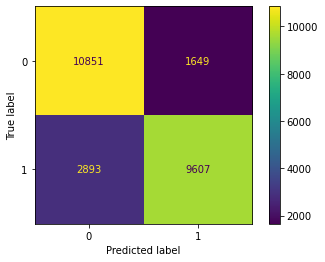

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, rnn_pred)).plot()
plt.show()

In [ ]:
# Check F1 Score
rnn_f1 = f1_score(y_test, rnn_pred)
rnn_f1

0.8088061963293484

In [ ]:
# Check Recall
rnn_recall = recall_score(y_test, rnn_pred)
rnn_recall

0.76856

In [ ]:
# Check Precision
rnn_precision = precision_score(y_test, rnn_pred)
rnn_precision

0.853500355366027

## LSTM Model

Next we will build a LSTM model, using a LSTM layer instead of the simple RNN.

In [ ]:
#Initialize and build the model

lstm_classifier = Sequential()

lstm_classifier.add(Embedding(max_words, 32, input_length=maxlength ) )

lstm_classifier.add(LSTM(20, input_shape = (max_words, maxlength) ))
lstm_classifier.add(Dropout(0.2))

lstm_classifier.add(Dense(1, activation='sigmoid', name='output'))

In [ ]:
lstm_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           640000    
                                                                 
 lstm (LSTM)                 (None, 20)                4240      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 output (Dense)              (None, 1)                 21        
                                                                 
Total params: 644,261
Trainable params: 644,261
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the classifier

lstm_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
# Fit the model to the training data

history = lstm_classifier.fit(x_train, y_train, validation_split = 0.2, epochs=100, batch_size=100, verbose=1, callbacks=es)

Epoch 1/100
200/200 [==============================] - 8s 14ms/step - loss: 0.5030 - acc: 0.7473 - val_loss: 0.3241 - val_acc: 0.8622
Epoch 2/100
200/200 [==============================] - 1s 7ms/step - loss: 0.2491 - acc: 0.9065 - val_loss: 0.3206 - val_acc: 0.8650
Epoch 3/100
200/200 [==============================] - 2s 8ms/step - loss: 0.1550 - acc: 0.9488 - val_loss: 0.3603 - val_acc: 0.8642
Epoch 4/100
200/200 [==============================] - 2s 8ms/step - loss: 0.1015 - acc: 0.9704 - val_loss: 0.4598 - val_acc: 0.8526
Epoch 5/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0683 - acc: 0.9810 - val_loss: 0.5181 - val_acc: 0.8486
Epoch 6/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0482 - acc: 0.9879 - val_loss: 0.5223 - val_acc: 0.8456
Epoch 7/100
200/200 [==============================] - 2s 7ms/step - loss: 0.0387 - acc: 0.9894 - val_loss: 0.6298 - val_acc: 0.8424
Epoch 8/100
200/200 [==============================] - 1s 7ms/step -

In [ ]:
# Score the data on the test set

lstm_score = lstm_classifier.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 5s 6ms/step - loss: 1.0168 - acc: 0.8206


In [ ]:
lstm_score

[1.0168325901031494, 0.8206400275230408]

In [ ]:
lstm_pred = lstm_classifier.predict(x_test)

In [ ]:
# Reshape our predictions and round them off to Integers
lstm_pred = np.reshape(lstm_pred, (y_test.shape)).round(1).astype('int64')
lstm_pred

array([1, 0, 0, ..., 1, 0, 0])

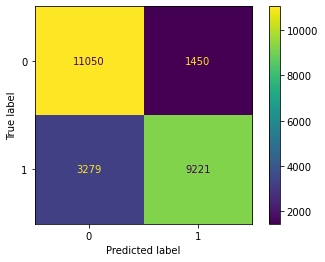

In [ ]:
# Adding spacing to facilitate the print-out
#
#
#
#
#
#
#
#
#
#
#
ConfusionMatrixDisplay(confusion_matrix(y_test, lstm_pred)).plot()
plt.show()

In [ ]:
# Check F1 Score
lstm_f1 = f1_score(y_test, lstm_pred)
lstm_f1

0.7959086789521385

In [ ]:
# Check Recall Score
lstm_recall = recall_score(y_test, lstm_pred)
lstm_recall

0.73768

In [ ]:
# Check Precision Score
lstm_precision = precision_score(y_test, lstm_pred)
lstm_precision

0.8641177021834879

## Conclusions

We built two models: one using a simple RNN and one using LSTMs. The results are summarized in a dataframe below:

In [ ]:
results = [['rnn', rnn_score[1], rnn_f1, rnn_recall, rnn_precision], ['lstm', lstm_score[1], lstm_f1, lstm_recall, lstm_precision]]
results_df = pd.DataFrame(results, columns=['Model Type', 'Accuracy', 'F1', 'Recall', 'Precision'])
results_df

,Model Type,Accuracy,F1,Recall,Precision
0,rnn,0.82592,0.808806,0.76856,0.853500
1,lstm,0.82064,0.795909,0.73768,0.864118


In [ ]:
# Calculate percentage differences between our two models
results_df.iloc[:,1:].pct_change()

,Accuracy,F1,Recall,Precision
0,NaN,NaN,NaN,NaN
1,-0.006393,-0.015946,-0.040179,0.01244


We can see that the Simple RNN gave us slightly better performance overall, though the two approaches are very similar, with only 0.6% accuracy difference.

The biggest difference in the confusion matrix is that there are approx 400 fewer false negatives (and approx 200 fewer false positives) using the Simple RNN approach.

It is almost certain that our hyperparameters could be tuned with further experimentation. I set them using best guesses, and generally targeted fewer results for computational expediency. In particular, the number of units output by our RNN layers could be increased (I picked 20 because it is fairly low).

Another way to improve our model would be to use pre-trained embeddings, such as GloVe. As the majority of our parameters are in the embedding layer, this would free up computing resources for the later layers, which could then be made more complex.